In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Activation, BatchNormalization, Input, Embedding, Dot, Dense, Flatten
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping

from wordcloud import WordCloud
%matplotlib inline

c:\Udemy\MLOps Course\Hybrid Anime Recommender\venv\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/attr_value.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
c:\Udemy\MLOps Course\Hybrid Anime Recommender\venv\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/tensor.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
c:\Udemy\MLOps Course\Hybrid Anime Recommender\venv\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/resour

# Reading Animelist.csv

In [2]:
import os

In [3]:
INPUT_DIR = os.path.join("..", "artifacts", "raw")

In [4]:
rating_df = pd.read_csv(INPUT_DIR+"/animelist.csv", low_memory=True, usecols = ["user_id", "anime_id", "rating"])

In [5]:
rating_df.head()

,user_id,anime_id,rating
0,0,67,9
1,0,6702,7
2,0,242,10
3,0,4898,0
4,0,21,10


In [6]:
len(rating_df)

5000000

# Data Processing

In [7]:
n_ratings = rating_df["user_id"].value_counts()
rating_df = rating_df[rating_df["user_id"].isin(n_ratings[n_ratings >= 400].index)].copy()

In [8]:
len(rating_df)

3246641

In [9]:
min_rating = min(rating_df["rating"])

In [10]:
max_rating = max(rating_df["rating"])

In [11]:
avg_rating = np.mean(rating_df["rating"])

In [12]:
min_rating

0

In [13]:
max_rating

10

In [14]:
avg_rating

np.float64(4.122732695114736)

In [15]:
rating_df["rating"] = rating_df["rating"].apply(lambda x: (x-min_rating)/(max_rating-min_rating)).values.astype(np.float64)

In [16]:
rating_df.duplicated().sum()

np.int64(0)

In [17]:
rating_df.isnull().sum()

user_id     0
anime_id    0
rating      0
dtype: int64

In [18]:
user_ids = rating_df["user_id"].unique().tolist()
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
user2user_decoded = {i: x for i, x in enumerate(user_ids)}
rating_df["user"] = rating_df["user_id"].map(user2user_encoded)

#### 4052: 996    ->      encoded
#### 996: 4052    ->      decoded

In [19]:
rating_df.head()

,user_id,anime_id,rating,user
213,2,24833,0.0,0
214,2,235,1.0,0
215,2,36721,0.0,0
216,2,40956,0.0,0
217,2,31933,0.0,0


In [20]:
n_user = len(user2user_encoded)

In [21]:
n_user

4203

In [22]:
anime_ids = rating_df["anime_id"].unique().tolist()
anime2anime_encoded = {x: i for i, x in enumerate(anime_ids)}
anime2anime_decoded = {i: x for i, x in enumerate(anime_ids)}
rating_df["anime"] = rating_df["anime_id"].map(anime2anime_encoded)

In [23]:
rating_df.head()

,user_id,anime_id,rating,user,anime
213,2,24833,0.0,0,0
214,2,235,1.0,0,1
215,2,36721,0.0,0,2
216,2,40956,0.0,0,3
217,2,31933,0.0,0,4


In [24]:
n_anime = len(anime2anime_encoded)
n_anime

17149

In [25]:
rating_df = rating_df.sample(frac=1, random_state=43).reset_index(drop=True)

In [26]:
rating_df.head()

,user_id,anime_id,rating,user,anime
0,457,18153,0.9,120,1377
1,4903,20507,0.7,1195,1216
2,6313,23325,0.0,1591,1239
3,15851,37491,0.0,4024,1813
4,1596,29803,0.9,415,353


In [ ]:
X = rating_df[["user", "anime"]].values
y = rating_df["rating"]

In [28]:
test_size = 1000
train_indices = rating_df.shape[0] - test_size

In [29]:
rating_df.shape[0]

3246641

In [30]:
X_train, X_test, y_train, y_test = (
    X[: train_indices],
    X[train_indices :],
    y[: train_indices],
    y[train_indices :],
)

In [31]:
len(X_train)

3245641

In [32]:
len(X_test)

1000

In [33]:
X_train_array = [X_train[: , 0], X_train[: , 1]]
X_test_array = [X_test[: , 0], X_test[: , 1]]

# Model Architechture

In [34]:
def RecommenderNet():
    embedding_size = 128

    user = Input(name="user", shape=[1])
    anime = Input(name="anime", shape=[1])

    user_embedding = Embedding(name="user_embedding", input_dim=n_user, output_dim=embedding_size)(user)
    anime_embedding = Embedding(name="anime_embedding", input_dim=n_anime, output_dim=embedding_size)(anime)

    x = Dot(name="dot_product", normalize=True, axes=2)([user_embedding, anime_embedding])

    x = Flatten()(x)

    x = Dense(1, kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation("sigmoid")(x)

    model = Model(inputs=[user, anime], outputs=x)
    model.compile(loss="binary_crossentropy", metrics=["mae", "mse"], optimizer="Adam")
    return model

In [35]:
model = RecommenderNet()

In [36]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ user (InputLayer)   │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ anime (InputLayer)  │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_embedding      │ (None, 1, 128)    │    537,984 │ user[0][0]        │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ anime_embedding     │ (None, 1, 128)    │  2,195,072 │ anime[0][0]       │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot_product (Dot)   │ (None, 1, 1)      │          0 │ user_embedding[0… │
│                     │                   │            │ anime_embedding[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 1)         │          0 │ dot_product[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1)         │          2 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 1)         │          4 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 1)         │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,733,062 (10.43 MB)

 Trainable params: 2,733,060 (10.43 MB)

 Non-trainable params: 2 (8.00 B)

In [37]:
# Learning Rate -> lr

start_lr = 0.00001
min_lr = 0.00001
max_lr = 0.00005
batch_size = 10000

ramup_epochs = 5
sustain_epochs = 0
exp_decay = 0.8

def lrfn(epoch):
    if epoch < ramup_epochs:
        return (max_lr - start_lr)/ramup_epochs*epoch + start_lr
    elif epoch < ramup_epochs + sustain_epochs:
        return max_lr
    else:
        return (max_lr - min_lr) * exp_decay ** (epoch-ramup_epochs-sustain_epochs)+min_lr

In [38]:
lr_callback = LearningRateScheduler(lambda epoch:lrfn(epoch), verbose=0)
checkpoint_filepath = './weights.weights.h5'

model_checkpoint = ModelCheckpoint(filepath=checkpoint_filepath, save_weights_only=True, monitor="val_loss", mode="min", save_best_only=True)

early_stopping = EarlyStopping(patience=3, monitor="val_loss", mode="min", restore_best_weights=True)

In [39]:
my_callbacks = [model_checkpoint, lr_callback, early_stopping]

In [40]:
history = model.fit(
    x = X_train_array,
    y = y_train,
    batch_size = batch_size,
    epochs = 20,
    verbose = 1,
    validation_data = (X_test_array, y_test),
    callbacks = my_callbacks,
)

Epoch 1/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - loss: 0.7648 - mae: 0.3757 - mse: 0.1855 - val_loss: 0.6958 - val_mae: 0.3608 - val_mse: 0.1570 - learning_rate: 1.0000e-05
Epoch 2/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - loss: 0.7615 - mae: 0.3745 - mse: 0.1841 - val_loss: 0.7313 - val_mae: 0.3665 - val_mse: 0.1722 - learning_rate: 1.8000e-05
Epoch 3/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step - loss: 0.7561 - mae: 0.3725 - mse: 0.1819 - val_loss: 0.7496 - val_mae: 0.3696 - val_mse: 0.1788 - learning_rate: 2.6000e-05
Epoch 4/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - loss: 0.7485 - mae: 0.3697 - mse: 0.1787 - val_loss: 0.7480 - val_mae: 0.3691 - val_mse: 0.1781 - learning_rate: 3.4000e-05


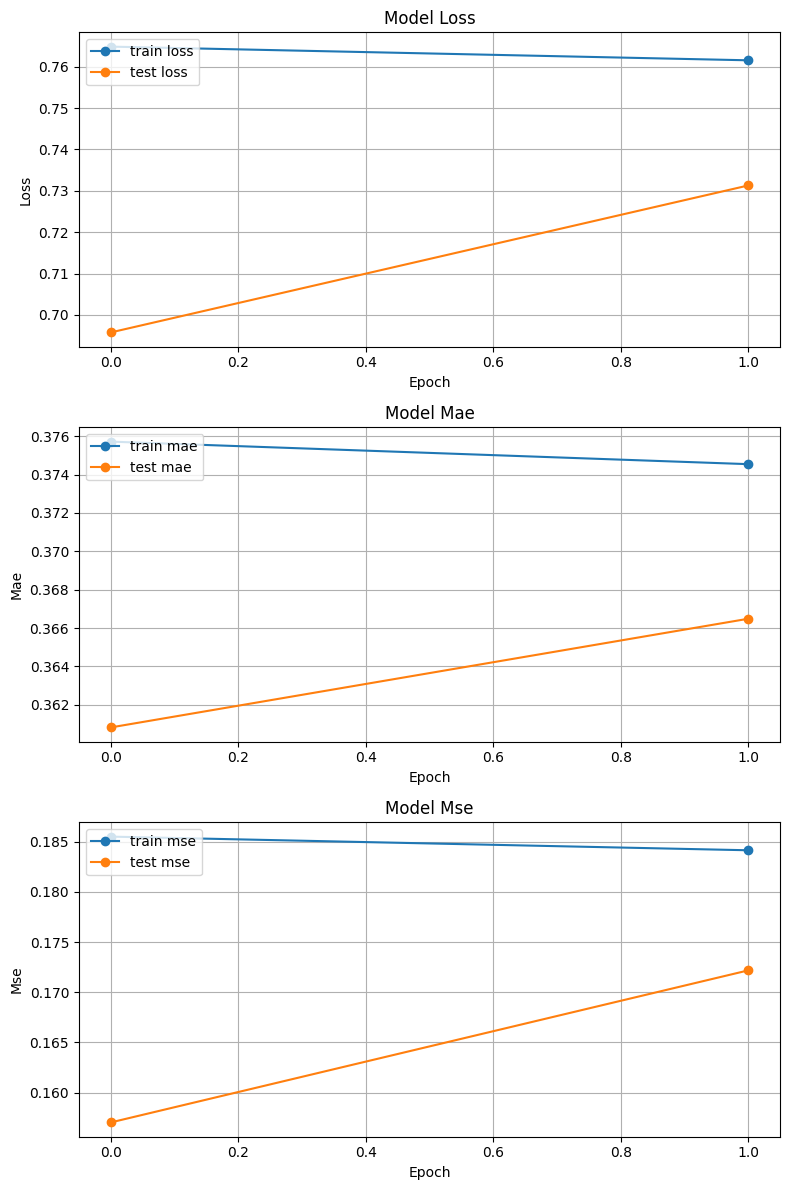

In [41]:
metrics = ["loss", "mae", "mse"]

fig, axes = plt.subplots(len(metrics), 1, figsize=(8, len(metrics) * 4))

for i, metric in enumerate(metrics):
    ax = axes[i]
    ax.plot(history.history[metric][0:2], marker="o", label = f"train {metric}")
    ax.plot(history.history[f"val_{metric}"][0:2], marker="o", label = f"test {metric}")
    ax.set_title(f"Model {metric.capitalize()}")
    ax.set_ylabel(metric.capitalize())
    ax.set_xlabel("Epoch")
    ax.legend(loc="upper left")
    ax.grid(True)

plt.tight_layout()
plt.show()

In [42]:
def extract_weights(name, model):
    weight_layer = model.get_layer(name)
    weights = weight_layer.get_weights()[0]
    weights = weights/np.linalg.norm(weights,axis=1).reshape((-1,1))
    return weights

In [43]:
anime_weights = extract_weights("anime_embedding", model)

In [44]:
user_weights = extract_weights("user_embedding", model)

#### Reading Anime.csv

In [45]:
df= pd.read_csv(INPUT_DIR+"/anime.csv", low_memory=True)
df.head(2)

,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,...,Score-10,Score-9,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,カウボーイビバップ,TV,26,"Apr 3, 1998 to Apr 24, 1999",Spring 1998,...,229170.0,182126.0,131625.0,62330.0,20688.0,8904.0,3184.0,1357.0,741.0,1580.0
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space",Cowboy Bebop:The Movie,カウボーイビバップ 天国の扉,Movie,1,"Sep 1, 2001",Unknown,...,30043.0,49201.0,49505.0,22632.0,5805.0,1877.0,577.0,221.0,109.0,379.0


In [46]:
df = df.replace("Unknown",np.nan)

In [47]:
def get_anime_name(anime_id):
    try:
        name = df[df.anime_id == anime_id].eng_version.values[0]
        if name is np.nan:
            name = df[df.anime_id == anime_id].Name.values[0]
    except:
        print("Error")
    return name

In [48]:
df["anime_id"] = df["MAL_ID"]
df["eng_version"] = df["English name"]
df["eng_version"] = df.anime_id.apply(lambda x: get_anime_name(x))

In [49]:
df.head(2)

,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,...,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1,anime_id,eng_version
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,カウボーイビバップ,TV,26,"Apr 3, 1998 to Apr 24, 1999",Spring 1998,...,131625.0,62330.0,20688.0,8904.0,3184.0,1357.0,741.0,1580.0,1,Cowboy Bebop
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space",Cowboy Bebop:The Movie,カウボーイビバップ 天国の扉,Movie,1,"Sep 1, 2001",NaN,...,49505.0,22632.0,5805.0,1877.0,577.0,221.0,109.0,379.0,5,Cowboy Bebop:The Movie


In [50]:
get_anime_name(8)

'Beet the Vandel Buster'

In [51]:
df.sort_values(by=["Score"],
               inplace=True,
               ascending=False,
               kind="quicksort",
               na_position="last"
               )

In [52]:
df.columns

Index(['MAL_ID', 'Name', 'Score', 'Genres', 'English name', 'Japanese name',
       'Type', 'Episodes', 'Aired', 'Premiered', 'Producers', 'Licensors',
       'Studios', 'Source', 'Duration', 'Rating', 'Ranked', 'Popularity',
       'Members', 'Favorites', 'Watching', 'Completed', 'On-Hold', 'Dropped',
       'Plan to Watch', 'Score-10', 'Score-9', 'Score-8', 'Score-7', 'Score-6',
       'Score-5', 'Score-4', 'Score-3', 'Score-2', 'Score-1', 'anime_id',
       'eng_version'],
      dtype='object')

In [53]:
df = df[["anime_id", "eng_version", "Score", "Genres", "Episodes", "Type", "Premiered", "Members"]]

In [54]:
df.head()

,anime_id,eng_version,Score,Genres,Episodes,Type,Premiered,Members
3971,5114,Fullmetal Alchemist:Brotherhood,9.19,"Action, Military, Adventure, Comedy, Drama, Ma...",64,TV,Spring 2009,2248456
15926,40028,Attack on Titan Final Season,9.17,"Action, Military, Mystery, Super Power, Drama,...",16,TV,Winter 2021,733260
5683,9253,Steins;Gate,9.11,"Thriller, Sci-Fi",24,TV,Spring 2011,1771162
14963,38524,Attack on Titan Season 3 Part 2,9.1,"Action, Drama, Fantasy, Military, Mystery, Sho...",10,TV,Spring 2019,1073626
9913,28977,Gintama Season 4,9.1,"Action, Comedy, Historical, Parody, Samurai, S...",51,TV,Spring 2015,404121


In [55]:
def get_anime_frame(anime,df):
    if isinstance(anime, int):
        return df[df.anime_id == anime]
    if isinstance(anime, str):
        return df[df.eng_version == anime]

In [56]:
get_anime_frame(40028, df)

,anime_id,eng_version,Score,Genres,Episodes,Type,Premiered,Members
15926,40028,Attack on Titan Final Season,9.17,"Action, Military, Mystery, Super Power, Drama,...",16,TV,Winter 2021,733260


In [57]:
get_anime_frame("Death Note", df)

,anime_id,eng_version,Score,Genres,Episodes,Type,Premiered,Members
1393,1535,Death Note,8.63,"Mystery, Police, Psychological, Supernatural, ...",37,TV,Fall 2006,2589552


#### Anime_with_sypnopsis.csv

In [58]:
cols = ["MAL_ID","Name", "Genres", "sypnopsis"]

In [59]:
synopsis_df = pd.read_csv(INPUT_DIR+"/anime_with_synopsis.csv", usecols=cols)

In [60]:
synopsis_df.head(1)

,MAL_ID,Name,Genres,sypnopsis
0,1,Cowboy Bebop,"Action, Adventure, Comedy, Drama, Sci-Fi, Space","In the year 2071, humanity has colonized sever..."


In [61]:
def get_sypnopsis(anime, df):
    if isinstance(anime,int):
        return synopsis_df[synopsis_df.MAL_ID == anime].sypnopsis.values[0]
    if isinstance(anime,str):
        return synopsis_df[synopsis_df.Name == anime].sypnopsis.values[0]
    

In [62]:
get_sypnopsis(40028, df)

"Gabi Braun and Falco Grice have been training their entire lives to inherit one of the seven titans under Marley's control and aid their nation in eradicating the Eldians on Paradis. However, just as all seems well for the two cadets, their peace is suddenly shaken by the arrival of Eren Yeager and the remaining members of the Survey Corps. Having finally reached the Yeager family basement and learned about the dark history surrounding the titans, the Survey Corps has at long last found the answer they so desperately fought to uncover. With the truth now in their hands, the group set out for the world beyond the walls. In Shingeki no Kyojin: The Final Season , two utterly different worlds collide as each party pursues its own agenda in the long-awaited conclusion to Paradis' fight for freedom."

In [63]:
get_sypnopsis("Death Note", df)

"shinigami, as a god of death, can kill any person—provided they see their victim's face and write their victim's name in a notebook called a Death Note. One day, Ryuk, bored by the shinigami lifestyle and interested in seeing how a human would use a Death Note, drops one into the human realm. High school student and prodigy Light Yagami stumbles upon the Death Note and—since he deplores the state of the world—tests the deadly notebook by writing a criminal's name in it. When the criminal dies immediately following his experiment with the Death Note, Light is greatly surprised and quickly recognizes how devastating the power that has fallen into his hands could be. With this divine capability, Light decides to extinguish all criminals in order to build a new world where crime does not exist and people worship him as a god. Police, however, quickly discover that a serial killer is targeting criminals and, consequently, try to apprehend the culprit. To do this, the Japanese investigators

# Content-Based Recommendation

In [64]:
pd.set_option("max_colwidth", None)

In [65]:
df.head(2)

,anime_id,eng_version,Score,Genres,Episodes,Type,Premiered,Members
3971,5114,Fullmetal Alchemist:Brotherhood,9.19,"Action, Military, Adventure, Comedy, Drama, Magic, Fantasy, Shounen",64,TV,Spring 2009,2248456
15926,40028,Attack on Titan Final Season,9.17,"Action, Military, Mystery, Super Power, Drama, Fantasy, Shounen",16,TV,Winter 2021,733260


In [66]:
synopsis_df.head(2)

,MAL_ID,Name,Genres,sypnopsis
0,1,Cowboy Bebop,"Action, Adventure, Comedy, Drama, Sci-Fi, Space","In the year 2071, humanity has colonized several of the planets and moons of the solar system leaving the now uninhabitable surface of planet Earth behind. The Inter Solar System Police attempts to keep peace in the galaxy, aided in part by outlaw bounty hunters, referred to as ""Cowboys."" The ragtag team aboard the spaceship Bebop are two such individuals. Mellow and carefree Spike Spiegel is balanced by his boisterous, pragmatic partner Jet Black as the pair makes a living chasing bounties and collecting rewards. Thrown off course by the addition of new members that they meet in their travels—Ein, a genetically engineered, highly intelligent Welsh Corgi; femme fatale Faye Valentine, an enigmatic trickster with memory loss; and the strange computer whiz kid Edward Wong—the crew embarks on thrilling adventures that unravel each member's dark and mysterious past little by little. Well-balanced with high density action and light-hearted comedy, Cowboy Bebop is a space Western classic and an homage to the smooth and improvised music it is named after."
1,5,Cowboy Bebop: Tengoku no Tobira,"Action, Drama, Mystery, Sci-Fi, Space","other day, another bounty—such is the life of the often unlucky crew of the Bebop. However, this routine is interrupted when Faye, who is chasing a fairly worthless target on Mars, witnesses an oil tanker suddenly explode, causing mass hysteria. As casualties mount due to a strange disease spreading through the smoke from the blast, a whopping three hundred million woolong price is placed on the head of the supposed perpetrator. With lives at stake and a solution to their money problems in sight, the Bebop crew springs into action. Spike, Jet, Faye, and Edward, followed closely by Ein, split up to pursue different leads across Alba City. Through their individual investigations, they discover a cover-up scheme involving a pharmaceutical company, revealing a plot that reaches much further than the ragtag team of bounty hunters could have realized."


In [84]:
def find_similar_animes(name, anime_weights,anime2anime_encoded, 
                        anime2anime_decoded, df, synopsis_df, n=10, 
                        return_dist=False, neg=False):
    
    try:
        index = get_anime_frame(name,df).anime_id.values[0]
        encoded_index = anime2anime_encoded.get(index)
        

        weights = anime_weights

        dists = np.dot(weights, weights[encoded_index])
        sorted_dists = np.argsort(dists)

        n=n+1

        if neg:
            closest = sorted_dists[:n]
        else:
            closest = sorted_dists[-n:]

        print(f"Anime closest to {name}")

        if return_dist:
            return dists, closest
        
        SimilarityArr = []

        for close in closest:
            decoded_id = anime2anime_decoded.get(close)

            # synopsis = get_sypnopsis(decoded_id,synopsis_df)

            anime_frame = get_anime_frame(decoded_id,df)

            anime_name = anime_frame.eng_version.values[0]
            genre = anime_frame.Genres.values[0]
            similarity = dists[close]

            SimilarityArr.append({
                "anime_id" : decoded_id,
                "name" : anime_name,
                "similarity" : similarity,
                "genre" : genre,
                # "synopsis" : synopsis
             })
            
        Frame = pd.DataFrame(SimilarityArr).sort_values(by="similarity", ascending=False)

        return Frame[Frame.anime_id != index].drop(['anime_id'], axis=1)
    except Exception as e:
        print("Error Occured", e)

In [68]:
find_similar_animes(
    "Death Note",
    anime_weights,
    anime2anime_encoded,
    anime2anime_decoded,
    df,
    synopsis_df,
    n=2
    )

Anime closest to Death Note


,name,similarity,genre,synopsis
1,Maihime,0.351173,"Historical, Drama, Romance","lonely exchange student meets and falls in passionate love with a dancer. A girl who falls into madness when she learns her lover is going home to make his life. The wanderings of youth on the stage of 19th century Berlin. The legendary novel of Meiji writer Mori Ogai, ""Maihime (dancing girl),"" adapted by Ga-nime ""School Girl"" producer Oku Shutaro who shows us his illustration talent and appoints Ms FURUYA Akisa for the booklets, slide shows, and animation of this Ga-nime. Over the background of a foreign country, we discover all the pathetic, poetic feelings of this elegant story as the wind of fresh artistic images brings it to life. (Source: Toei-Anim.co.jp)"
0,Tomoe ga Yuku!,0.316371,"Action, Drama, Romance, Thriller, Shoujo","The title character of Tomoe ga Yuku! (Tomoe Will Go!) is gutsy enough to roller skate down freeways for thrills. After losing a friend in a roller skating accident, Tomoe joins a stunt group called Green Ship. Although still mourning her friend's death, Tomoe has no reservations about embracing a relationship with the group's leader, Kazusa. Soon she discovers Green Ship is a front for an assassin training camp. She must flee her new life and love and rekindle her fiery spirit in order to fight against the organization which wants her dead. (Source: Animerica Extra December 2001)"


In [69]:
def find_similar_users(item_input, user_weights, user2user_encoded, user2user_decoded, n=10, return_dist=False,neg=False):
    try:
        index=item_input
        encoded_index = user2user_encoded.get(index)

        weights = user_weights

        dists = np.dot(weights, weights[encoded_index])
        sorted_dists = np.argsort(dists)

        n=n+1

        if neg:
            closest = sorted_dists[:n]
        else:
            closest = sorted_dists[-n:]

        if return_dist:
            return dists, closest
        
        SimilarityArr = []

        for close in closest:
            similarity  = dists[close]

            if isinstance(item_input, int):
                decoded_id = user2user_decoded.get(close)
                SimilarityArr.append({
                    "similar_users" : decoded_id,
                    "similarity" : similarity
                    })
        
        similar_users = pd.DataFrame(SimilarityArr).sort_values(by="similarity", ascending=False)
        similar_users = similar_users[similar_users.similar_users != item_input]
        return similar_users
    except Exception as e:
        print("Error Occured", e)

In [70]:
find_similar_users(int(11880),user_weights,user2user_encoded,user2user_decoded)

,similar_users,similarity
9,14957,0.338787
8,8901,0.309729
7,5211,0.296490
6,4467,0.294481
5,15558,0.288651
4,7854,0.285352
3,8810,0.279726
2,5781,0.268531
1,9475,0.266854
0,7032,0.259196


In [71]:
def showWordCould(all_genres):
    genres_cloud = WordCloud(width=700, height=400, background_color='white', colormap='gnuplot').generate_from_frequencies(all_genres)
    plt.figure(figsize=(10,8))
    plt.imshow(genres_cloud,interpolation="bilinear")
    plt.axis("off")
    plt.show()

In [72]:
from collections import defaultdict

In [73]:
def getFavGenre(frame, plot=False):
    frame.dropna(inplace=False)
    all_genres = defaultdict(int)

    genres_list = []
    for genres in frame["Genres"]:
        if isinstance(genres,str):
            for genre in genres.split(','):
                genres_list.append(genre)
                all_genres[genre.strip()] += 1

    if plot:
        showWordCould(all_genres)

    return genres_list

In [74]:
def get_user_preferences(user_id, rating_df, df, plot=False):
    animes_watched_by_user = rating_df[rating_df.user_id == user_id]

    user_rating_percentile = np.percentile(animes_watched_by_user.rating, 75)

    animes_watched_by_user = animes_watched_by_user[animes_watched_by_user.rating >= user_rating_percentile]

    top_animes_user = (
        animes_watched_by_user.sort_values(by="rating", ascending=False).anime_id.values
    )

    anime_df_rows = df[df["anime_id"].isin(top_animes_user)]
    anime_df_rows = anime_df_rows[["eng_version", "Genres"]]

    if plot:
        getFavGenre(anime_df_rows,plot)

    return anime_df_rows

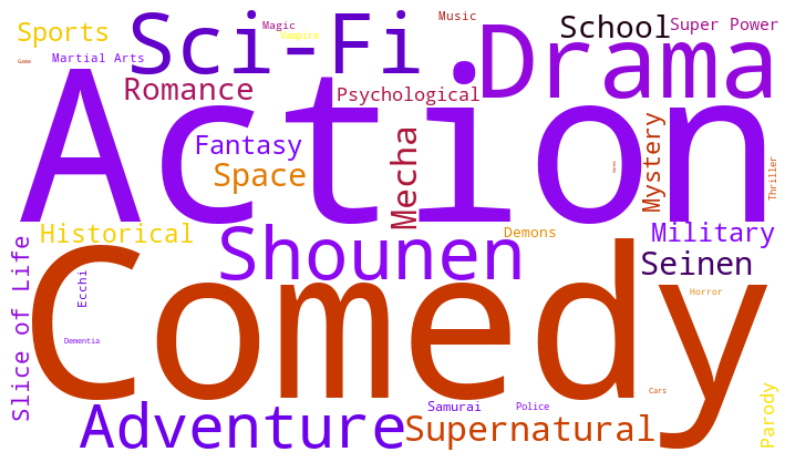

,eng_version,Genres
3971,Fullmetal Alchemist:Brotherhood,"Action, Military, Adventure, Comedy, Drama, Magic, Fantasy, Shounen"
9913,Gintama Season 4,"Action, Comedy, Historical, Parody, Samurai, Sci-Fi, Shounen"
6474,Hunter x Hunter,"Action, Adventure, Fantasy, Shounen, Super Power"
6006,Gintama Season 2,"Action, Sci-Fi, Comedy, Historical, Parody, Samurai, Shounen"
741,Legend of the Galactic Heroes,"Military, Sci-Fi, Space, Drama"
...,...,...
2575,Shootfighter Tekken,"Action, Martial Arts, Shounen"
8064,Samurai Flamenco,"Action, Comedy, Parody, Super Power"
510,Venus Wars,"Action, Sci-Fi, Adventure, Space"
6864,Saint Seiya Omega,"Action, Adventure, Fantasy, Shounen"


In [75]:
get_user_preferences(11880,rating_df, df, plot=True)

# User-Based Recommendation

In [76]:
def get_user_recommendations(similar_users, user_pref, df, synopsis_df, rating_df, n=10):
    recommended_animes = []
    anime_list = []

    for user_id in similar_users.similar_users.values:
        pref_list = get_user_preferences(int(user_id), rating_df, df)

        pref_list = pref_list[~pref_list.eng_version.isin(user_pref.eng_version.values)]

        if not pref_list.empty:
            anime_list.append(pref_list.eng_version.values)

    if anime_list:
            anime_list = pd.DataFrame(anime_list)

            sorted_list = pd.DataFrame(pd.Series(anime_list.values.ravel()).value_counts()).head(n)

            for i, anime_name in enumerate(sorted_list.index):
                n_user_pref = sorted_list[sorted_list.index == anime_name].values[0][0]

                if isinstance(anime_name, str):
                    frame = get_anime_frame(anime_name, df)
                    anime_id = frame.anime_id.values[0]
                    genre = frame.Genres.values[0]
                    synopsis = get_sypnopsis(int(anime_id), synopsis_df)

                    recommended_animes.append({
                        "n" : n_user_pref,
                        "anime_name" : anime_name,
                        "Genres" : genre,
                        "Synopsis" : synopsis
                    })
    return pd.DataFrame(recommended_animes).head(n)

In [77]:
similar_users = find_similar_users(int(11880),user_weights,user2user_encoded,user2user_decoded)

In [78]:
user_pref = get_user_preferences(11880,rating_df, df, plot=False)

In [81]:
get_user_recommendations(similar_users, user_pref,df, synopsis_df, rating_df,n=1)

,n,anime_name,Genres,Synopsis
0,8,Death Note,"Mystery, Police, Psychological, Supernatural, Thriller, Shounen","shinigami, as a god of death, can kill any person—provided they see their victim's face and write their victim's name in a notebook called a Death Note. One day, Ryuk, bored by the shinigami lifestyle and interested in seeing how a human would use a Death Note, drops one into the human realm. High school student and prodigy Light Yagami stumbles upon the Death Note and—since he deplores the state of the world—tests the deadly notebook by writing a criminal's name in it. When the criminal dies immediately following his experiment with the Death Note, Light is greatly surprised and quickly recognizes how devastating the power that has fallen into his hands could be. With this divine capability, Light decides to extinguish all criminals in order to build a new world where crime does not exist and people worship him as a god. Police, however, quickly discover that a serial killer is targeting criminals and, consequently, try to apprehend the culprit. To do this, the Japanese investigators count on the assistance of the best detective in the world: a young and eccentric man known only by the name of L."


# Hybrid Recommender System

In [87]:
def hybrid_recommendation(user_id, user_weight=0.5, content_weight=0.5):
    ## User Recommendation

    similar_users = find_similar_users(user_id,user_weights,user2user_encoded,user2user_decoded)
    user_pref = get_user_preferences(user_id,rating_df, df, plot=False)
    user_recommended_animes = get_user_recommendations(similar_users, user_pref,df, synopsis_df, rating_df)

    user_recommended_animes_list = user_recommended_animes["anime_name"].tolist()
    print(user_recommended_animes_list)

    ## Content Recommendation
    content_recommended_animes = []

    for anime in user_recommended_animes_list:
        similar_animes = find_similar_animes(anime, anime_weights, anime2anime_encoded, anime2anime_decoded, df, synopsis_df)

        if similar_animes is not None and not similar_animes.empty:
            content_recommended_animes.extend(similar_animes["name"].tolist())
        else:
            print(f"No similar anime found {anime}")

    combined_score = {}

    for anime in user_recommended_animes_list:
        combined_score[anime] = combined_score.get(anime,0) + user_weight

    for anime in content_recommended_animes:
        combined_score[anime] = combined_score.get(anime,0) + content_weight

    sorted_animes = sorted(combined_score.items(), key=lambda x:x[1], reverse=True)

    return [anime for anime, score in sorted_animes[:10]]


In [88]:
hybrid_recommendation(11880)

['Death Note', 'Code Geass:Lelouch of the Rebellion', 'Elfen Lied', 'Hyouka', 'Steins;Gate', "KonoSuba:God's Blessing on This Wonderful World! 2", 'My Teen Romantic Comedy SNAFU TOO!', 'Code Geass:Lelouch of the Rebellion R2', 'Spirited Away', "KonoSuba:God's Blessing on This Wonderful World!"]
Anime closest to Death Note
Anime closest to Code Geass:Lelouch of the Rebellion
Anime closest to Elfen Lied
Anime closest to Hyouka
Anime closest to Steins;Gate
Anime closest to KonoSuba:God's Blessing on This Wonderful World! 2
Anime closest to My Teen Romantic Comedy SNAFU TOO!
Anime closest to Code Geass:Lelouch of the Rebellion R2
Anime closest to Spirited Away
Anime closest to KonoSuba:God's Blessing on This Wonderful World!


['Death Note',
 'Code Geass:Lelouch of the Rebellion',
 'Elfen Lied',
 'Hyouka',
 'Steins;Gate',
 "KonoSuba:God's Blessing on This Wonderful World! 2",
 'My Teen Romantic Comedy SNAFU TOO!',
 'Code Geass:Lelouch of the Rebellion R2',
 'Spirited Away',
 "KonoSuba:God's Blessing on This Wonderful World!"]